In [68]:
# Predict on test set

import dataset
import importlib
import autoencoders
import classifiers
import numpy as np
import pandas as pd
import os
import pickle
import sklearn
import keras

importlib.reload(dataset)

save_dir = 'cached/fma_small_mfcc_genre2_w_encoder_2000_5fps'
mfcc_save_path = os.path.join(save_dir, 'mfcc.npy')
tracks_save_path = os.path.join(save_dir, 'tracks')
params_save_path = os.path.join(save_dir, 'params')
norms_save_path = os.path.join(save_dir, 'norms')
encoder_save_path = os.path.join(save_dir, 'encoder')
net_save_path = os.path.join(save_dir, 'net')

# try:
#     dataset.load_fma(sample_size=2000, save_dir=save_dir, fps=1, num_segments=10)
# except:
#     print('Data already loaded')

x = np.load(mfcc_save_path)# mfccs for all tracks
tracks = pd.read_pickle(tracks_save_path)
with open(params_save_path, 'rb') as pf: # dataset processing params
    sample_size, sr, fps, mfcc, num_segments, save_dir = pickle.load(pf)
with open(norms_save_path, 'rb') as nf:
    mean, std = pickle.load(nf)

# Shape for training
num_frames = int(x.shape[0] / (sample_size * num_segments * mfcc))
x = x.reshape(sample_size * num_segments, mfcc, num_frames, 1)

# Pad
scale = 2 ** 2
pad_frames = (int(num_frames / scale) + 1) * scale - num_frames
x_pad_frames = np.zeros((sample_size * num_segments, mfcc, pad_frames, 1))
x = np.concatenate((x, x_pad_frames), axis=2)
pad_mfcc = (int(mfcc / scale) + 1) * scale - mfcc
x_pad_mfcc = np.zeros((sample_size * num_segments, pad_mfcc, x.shape[2], 1))
x = np.concatenate((x, x_pad_mfcc), axis=1)

# Split
x_train, x_test = dataset.split_data(x)
print('Training shape', x_train.shape)
print('Test shape', x_test.shape)

# Normalize test set
x_test = (x_test - mean) / std

track_index = tracks.index
training_size = int(x_train.shape[0]/num_segments)
test_size = int(x_test.shape[0]/num_segments)
tidx_train, tidx_test = track_index[:training_size], tracks.index[training_size:]
print('Training tracks shape', tidx_train.shape)
print('Test tracks shape', tidx_test.shape)

# Load trained ae
# classifier = keras.models.load_model(net_save_path)
# encoder = keras.models.load_model(encoder_save_path)
inpdimx = x_test.shape[1]
inpdimy = x_test.shape[2]
model, encoder = classifiers.genre_classifier_conv(inpdimx, inpdimy, 2)
model.load_weights(net_save_path)

# Predict
y = encoder.predict(x_test)
# print('Prediction shape', y.shape)
print(len(y))

Training shape (27200, 24, 20, 1)
Test shape (6800, 24, 20, 1)
Training tracks shape (1360,)
Test tracks shape (340,)
3


In [72]:
# Reshape encodings
y_segment = np.concatenate((y[0].reshape(test_size * num_segments, -1),
                            y[1].reshape(test_size * num_segments, -1),
                            y[2].reshape(test_size * num_segments, -1)), axis=1)
print('Flattened encodings by segment shape', y_segment.shape)
y = np.concatenate((y[0].reshape(test_size, num_segments, -1),
                    y[1].reshape(test_size, num_segments, -1),
                    y[2].reshape(test_size, num_segments, -1)), axis=2)
print('Flattened encodings by track shape', y.shape)

Flattened encodings by segment shape (6800, 8760)
Flattened encodings by track shape (340, 20, 8760)


In [14]:
# Reshape encodings
y_segment = y.reshape(test_size * num_segments, -1)
print('Flattened encodings by segment shape', y_segment.shape)
y = y.reshape(test_size, num_segments, -1)
print('Flattened encodings by track shape', y.shape)

Flattened encodings by segment shape (6800, 12)
Flattened encodings by track shape (340, 20, 12)


In [83]:
# Approach A -> Reduce dimensionality by PCA to no of animation params
from sklearn.decomposition import PCA

reduced_dim = 20

pca = PCA(n_components=reduced_dim)
pca.fit(y_segment)
y_segment_red = pca.transform(y_segment)
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(y_segment_red)
y_segment_red = scaler.transform(y_segment_red)
print('Reduced encodings by segment shape', y_segment_red.shape)
y_red = y_segment_red.reshape(test_size, num_segments, int(y_segment_red.size / (test_size * num_segments)))
print('Reduced encodings by track shape', y_red.shape)
print('Variance retained: {}%'.format(pca.explained_variance_ratio_.sum()*100))
# pca.explained_variance_ratio_.cumsum()

# temp = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# temp = temp.transpose()
# pca = PCA(n_components=1)
# p = pca.fit(temp)
# pca.components_.transpose()

# rng = np.random.RandomState(1)
# X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
# pca = PCA(n_components=1)
# pca.fit(X)
# X_pca = pca.transform(X)
# print("original shape:   ", X.shape)
# print("transformed shape:", X_pca.shape)
# pca.explained_variance_.sum()*100

Reduced encodings by segment shape (6800, 20)
Reduced encodings by track shape (340, 20, 20)
Variance retained: 85.90970635414124%


In [39]:
# Approach B -> Reduce dimensionality by using K means
from sklearn.cluster import KMeans
# X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
# print(X.shape)
# kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# X = kmeans.transform(X)
# print(X.shape)
# X = 1 / (1 + X)
# print(X.sum(axis=1))
# X = X / X.sum(axis=1)[:,None]
# print(X)
# kmeans.score(X)
# kmeans.labels_
# kmeans.predict([[0, 0], [4, 4]])
# kmeans.cluster_centers_

reduced_dim = y_segment.shape[1] # 5
reduced_dim = 2

y_segment_scaled = sklearn.preprocessing.normalize(y_segment)

kmeans = KMeans(n_clusters=reduced_dim)
kmeans.fit(y_segment_scaled)
y_segment_red = kmeans.transform(y_segment_scaled)
y_segment_red = 1 / (1 + y_segment_red)
# y_segment_red = y_segment_red / y_segment_red.sum(axis=1)[:,None]
y_segment_red_scaled = y_segment_red / y_segment_red.sum(axis=1)[:,None]
print('Reduced encodings by segment shape', y_segment_red.shape)
y_red = y_segment_red.reshape(test_size, num_segments, int(y_segment_red.size / (test_size * num_segments)))
y_red_scaled = y_segment_red_scaled.reshape(test_size, num_segments, int(y_segment_red_scaled.size / (test_size * num_segments)))
print('Reduced encodings by track shape', y_red.shape)
print('Score', kmeans.score(y_segment_scaled))

Reduced encodings by segment shape (6800, 2)
Reduced encodings by track shape (340, 20, 2)
Score -874.6338499188423


In [84]:
y_curr = y_red # or y, y_red_scaled
encodings = {}
for i, idx in enumerate(tidx_test):
    encodings[idx] = y_curr[i, :, :]
for enc in encodings.values():
    encoding_shape = enc.shape
    break
print('Encoding shape', encoding_shape)

Encoding shape (20, 20)


In [85]:
# Separate a few genres

import pandas as pd
test_tracks = tracks.loc[tidx_test, :]
hiphop = test_tracks[test_tracks['track', 'genre_top'] == 'Hip-Hop']
folk = test_tracks[test_tracks['track', 'genre_top'] == 'Folk']
electronic = test_tracks[test_tracks['track', 'genre_top'] == 'Electronic']
instrumental = test_tracks[test_tracks['track', 'genre_top'] == 'Instrumental']
experimental = test_tracks[test_tracks['track', 'genre_top'] == 'Experimental']
international = test_tracks[test_tracks['track', 'genre_top'] == 'International']
rock = test_tracks[test_tracks['track', 'genre_top'] == 'Rock']

Plotting Folk


/home/rbiswas/.virtualenvs/deep-audioviz3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


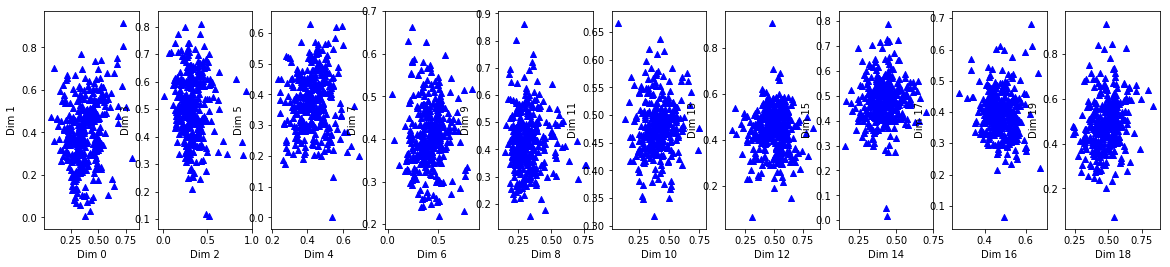

Plotting Electronic


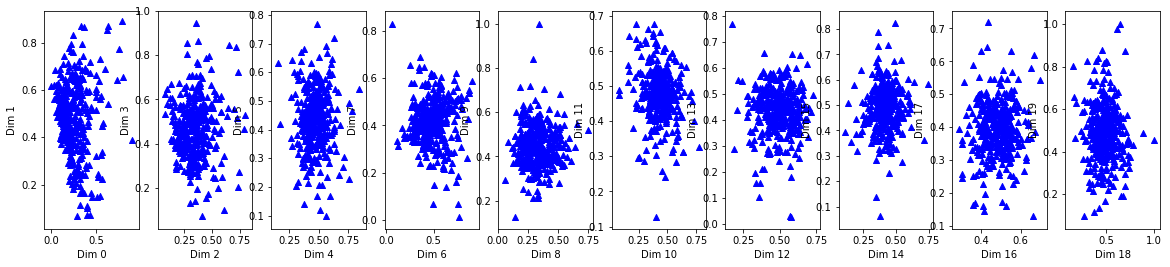

In [86]:
# Visualize 2 dimensions of the encodings for multiple segments in scatter plots

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 4)

sample = np.arange(int(num_segments/10))
np.random.shuffle(sample)

for genre in [folk, electronic]:
    for i,idx in enumerate(genre.index):
        if i==0:
            print('Plotting {0}'.format(genre['track', 'genre_top'][idx]))
        toplot = range(0,encoding_shape[1],2)
        for i, dim in enumerate(toplot):
            dim1 = dim
            dim2 = dim+1
            if dim2 >= encoding_shape[1]:
                continue
            encoded = encodings[idx]
            x_ = np.transpose(encoded[sample, dim1])
            y_ = np.transpose(encoded[sample, dim2])
            plt.subplot(1,len(toplot), i+1)
            plt.xlabel('Dim {0}'.format(dim1))
            plt.ylabel('Dim {0}'.format(dim2))
            plt.scatter(x_, y_, marker='^', c='blue')
    plt.show()

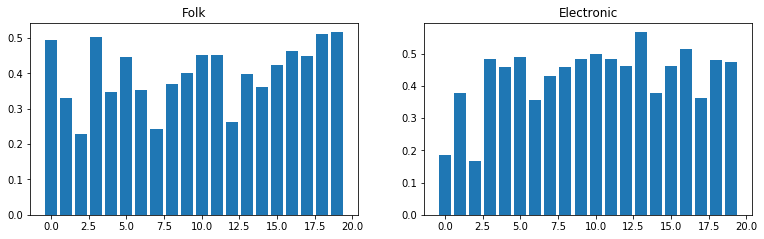

In [100]:
# Visualize encoings for random segment from multiple genres

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 12)

# for i, genre in enumerate([hiphop, folk, electronic, rock, instrumental, international, experimental]):
for i, genre in enumerate([folk, electronic]):
    # print(genre.shape)
    track_idx = genre.index[np.random.randint(genre.shape[0])]
    # print('Plotting {0} track {1}'.format(genre['track', 'genre_top'][track_idx], track_idx))
    encoding = encodings[track_idx]
    plt.subplot(3, 3, i+1)
    plt.title(genre['track', 'genre_top'][track_idx])
    plt.bar(np.arange(encoding.shape[1]), encoding[0,:])
plt.show()

Plotting Folk


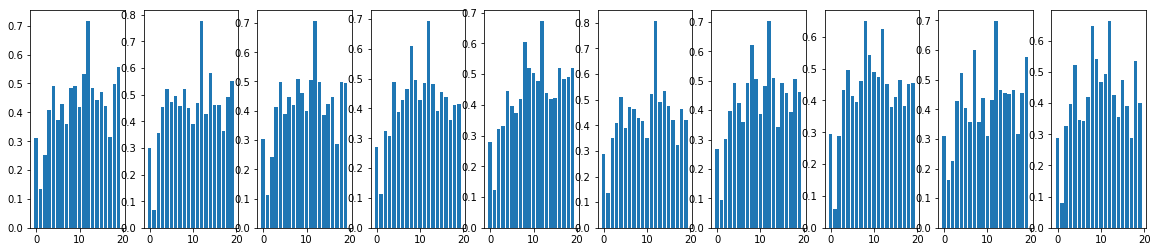

Plotting Electronic


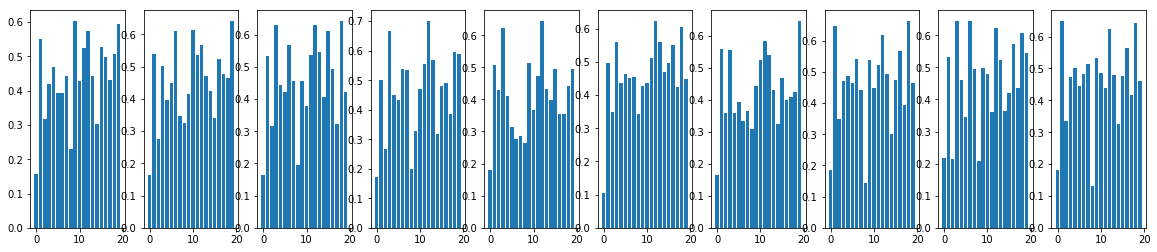

In [99]:
# Visualize the encodings of multiple segmets of the same track

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 4)

segments_to_visulize = 10

# for i, genre in enumerate([hiphop, folk, electronic, rock, instrumental, international, experimental]):
for i, genre in enumerate([folk, electronic]):
    track_idx = genre.index[np.random.randint(genre.shape[0])]
    print('Plotting {0}'.format(genre['track', 'genre_top'][track_idx]))
    encoding = encodings[track_idx]
    for i in range(segments_to_visulize):
        plt.subplot(1, segments_to_visulize, i+1)
        plt.bar(np.arange(encoding.shape[1]), encoding[i,:])
    plt.show()

Plotting encoding 1 of 2 for all segments


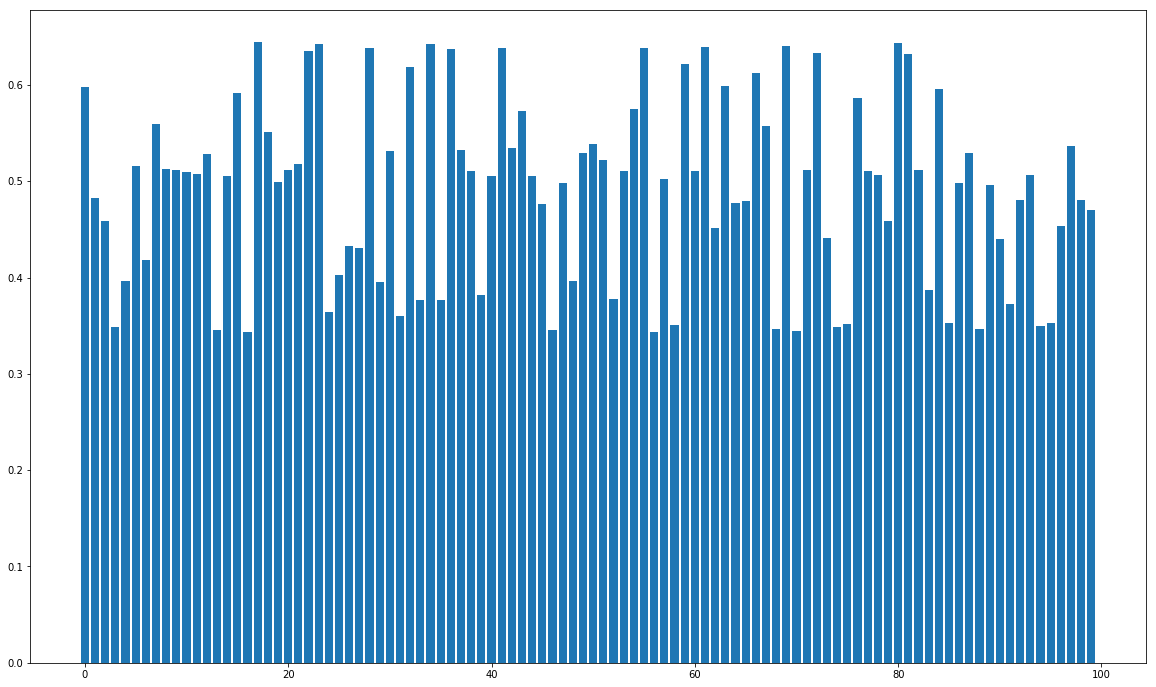

Plotting encoding 2 of 2 for all segments


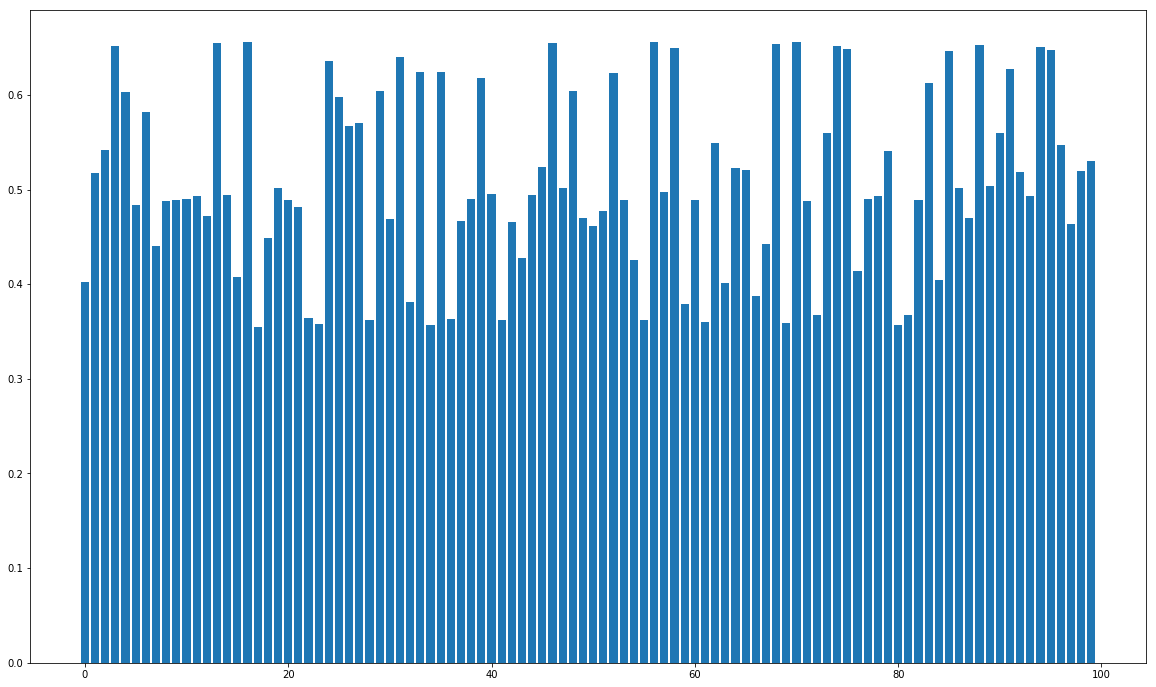

In [95]:
# Plot each encoded value separately for all segemts

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 12)

num_segmets_to_view = 100
idx = np.arange(num_segmets_to_view)
np.random.shuffle(idx)

y_curr = y_segment_red_scaled # change
# y_curr = sklearn.preprocessing.minmax_scale(y_curr, (0, 50))
for enc_num in range(y_curr.shape[1]):
    print('Plotting encoding {0} of {1} for all segments'.format(enc_num+1, y_curr.shape[1]))
    plt.bar(np.arange(num_segmets_to_view), y_curr[idx,enc_num])
    plt.show()

In [96]:
import scipy

y_curr = y_segment_red # y_segment change
# y_curr = sklearn.preprocessing.minmax_scale(y_curr, (0, 50))
for enc_num in range(y_curr.shape[1]):
    print('Describing encoding {0} of {1} for all segments'.format(enc_num+1, y_curr.shape[1]))
    print(scipy.stats.describe(y_curr[:, enc_num]))

Describing encoding 1 of 20 for all segments
DescribeResult(nobs=6800, minmax=(0.0, 1.0), mean=0.31623968, variance=0.022596644, skewness=0.7074511647224426, kurtosis=0.6192496386656727)
Describing encoding 2 of 20 for all segments
DescribeResult(nobs=6800, minmax=(0.0, 0.9999999), mean=0.4471453, variance=0.023750428, skewness=-0.011459611356258392, kurtosis=-0.1423744493966006)
Describing encoding 3 of 20 for all segments
DescribeResult(nobs=6800, minmax=(0.0, 1.0), mean=0.3293432, variance=0.015651576, skewness=1.0381335020065308, kurtosis=2.428923101586977)
Describing encoding 4 of 20 for all segments
DescribeResult(nobs=6800, minmax=(0.0, 1.0), mean=0.4912786, variance=0.017217472, skewness=0.022567111998796463, kurtosis=0.13896740914468486)
Describing encoding 5 of 20 for all segments
DescribeResult(nobs=6800, minmax=(0.0, 0.99999994), mean=0.4448773, variance=0.007961899, skewness=0.17624396085739136, kurtosis=1.9329147598986056)
Describing encoding 6 of 20 for all segments
Desc

IndexError: index 9 is out of bounds for axis 1 with size 9

In [16]:
# reduced_dim = 50

# kmeans = KMeans(n_clusters=reduced_dim)
# kmeans.fit(y_segment)
# y_segment_red = kmeans.transform(y_segment)
# y_segment_red = 1 / (1 + y_segment_red)
# y_segment_red = y_segment_red / y_segment_red.sum(axis=1)[:,None]
# # y_segment_red_scaled = y_segment_red / y_segment_red.sum(axis=1)[:,None]
# print('Reduced encodings by segment shape', y_segment_red.shape)
# y_red = y_segment_red.reshape(test_size, num_segments, int(y_segment_red.size / (test_size * num_segments)))
# # y_red_scaled = y_segment_red_scaled.reshape(test_size, num_segments, int(y_segment_red_scaled.size / (test_size * num_segments)))
# print('Reduced encodings by track shape', y_red.shape)
# print('Score', kmeans.score(y_segment))
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( y_segment_scaled )
  cluster_errors.append( clusters.inertia_ )


In [17]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

In [18]:
clusters_df

,cluster_errors,num_clusters
0,2587.294193,1
1,874.633680,2
2,630.276121,3
3,435.946610,4
4,323.678481,5
5,273.406432,6
6,233.312132,7
7,203.151923,8
8,183.821357,9
9,166.652126,10


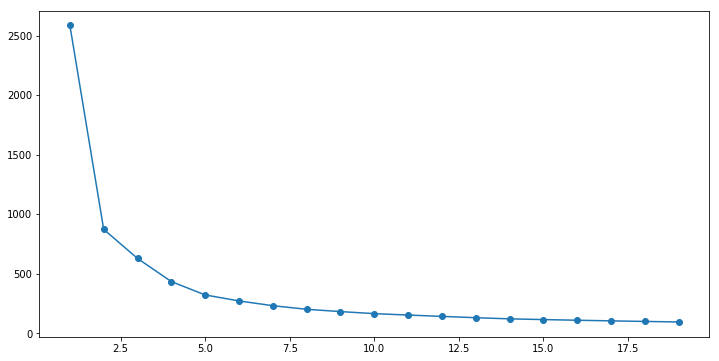

In [20]:
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 12)

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

For n_clusters = 2 The average silhouette_score is : 0.37237948


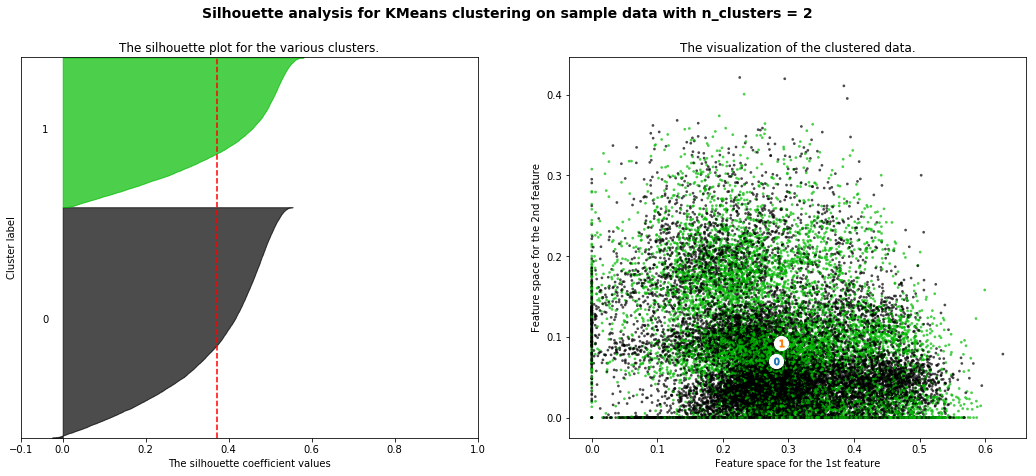

For n_clusters = 3 The average silhouette_score is : 0.27546078


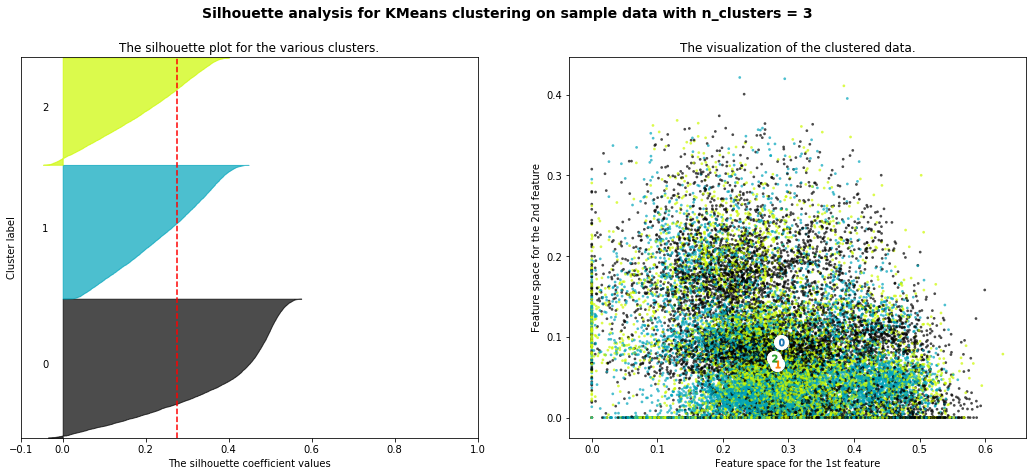

For n_clusters = 4 The average silhouette_score is : 0.23388572


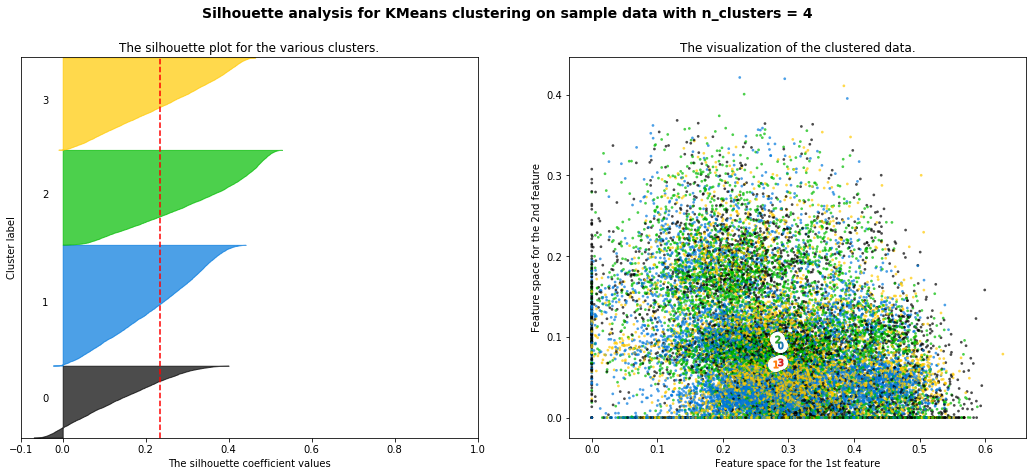

For n_clusters = 5 The average silhouette_score is : 0.2244199


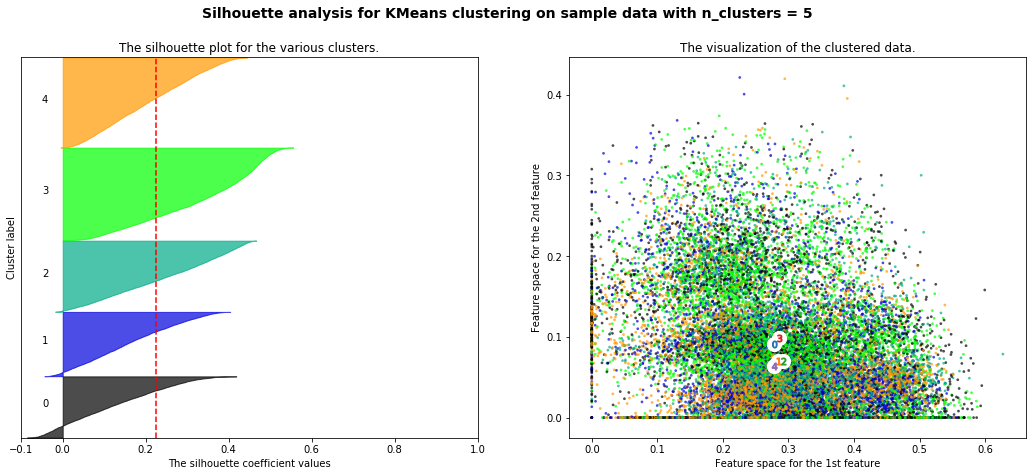

In [96]:
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn

cluster_range = range( 2, 6 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(y_segment) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict( y_segment )

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(y_segment, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(y_segment, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(y_segment[:, 0], y_segment[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()